In [1]:
import hiplot as hip
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200
import random
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
import os
import glob
import uproot3 as uproot
import scipy

from scipy.optimize import curve_fit
import scipy.stats as stats


import mplhep as hep
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use([hep.styles.ATLAS])

from IPython.core.display import display, HTML
display(HTML(
    '<style>'
        '#notebook { padding-top:0px !important; } ' 
        '.container { width:100% !important; } '
        '.end_space { min-height:0px !important; } '
    '</style>'
))

SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

%matplotlib inline

In [23]:
def loadDF(fileName,treeName,cols):
    ''' Function to load a root file '''
    tree=uproot.open(fileName)[treeName]
    df=tree.arrays(cols,outputtype=pd.DataFrame).reset_index(drop=True)
    return df

def loadDataInCfgFile(cfg):
    ''' Grab the files listed in a amptools config file '''
    keys=["LOOPDATA","LOOPBKGND","LOOPACCMC"]
    dfs={}
    with open(cfg) as c:
        for line in c.readlines():
            if line.startswith("loop") and "root" in line:
                tmp=line.rstrip().lstrip().split(" ")
                df=[]
                for key in keys:
                    if tmp[1]==key:
                        for f in tmp[2:]:
                            d=loadDF(f,"kin",["Weight","AccWeight","Mpi0eta","cosTheta_eta_hel","cosTheta_eta_gj","Mpi0p","Mpi0","Meta"])
                            if key=="LOOPBKGND":
                                d.Weight*=-1
                            df.append(d)
                        dfs[key]=pd.concat(df)
    return dfs


def loadTheory(tbin):
    theory_pred_floc="/d/grid17/ln16/dselector_v3/study_pwa/jupyter_plotting/theory_pred/"
    ''' Load the theory curves for the different m-projections '''
    theoryCurves=pd.read_csv(theory_pred_floc+"Waves_bin"+str(tbin)+".txt",sep='  ',
                           names=["D0++", "D1++", "D2++", "D1--", "D0+-", "D1+-"], engine='python')
    theoryCurves=theoryCurves.reset_index()
    theoryCurves.rename(columns={"index":"mass"},inplace=True)
    return theoryCurves

def loadMergedPols(fileName,histBaseName,pols):
    '''
    We use amptools' plotter program to make histograms that were output into separate root files
    Use this function to load the root file and grab the histogram you want ~ integrated over some set of polarizations
    '''
    totalValues=0
    for pol in pols:
        hist=uproot.open(fileName)["EtaPi0_"+pol+"_"+histBaseName]
        edges=hist.edges
        width=edges[1]-edges[0]
        value=hist.values
        totalValues+=value
    return totalValues, edges, width

def relBW(x,particle_mass,width):
    ''' Equation for relativistic breit-wigner'''
    gamma=np.sqrt(particle_mass*particle_mass*(particle_mass*particle_mass+width*width))
    k=2*np.sqrt(2)*particle_mass*width*gamma/np.pi/np.sqrt(particle_mass*particle_mass+gamma)
    return k / ((x*x - particle_mass*particle_mass)**2 + (particle_mass*width)**2)

def constructAltTheory(tbin):
    '''
    Everytime we call this we have to load all 5 t bins since we have to keep the same proportions across t-bins
    '''
    theories=[loadTheory(i).iloc[:,1:].sum() for i in range(1,6)]
    theories=[theory/theories[0]["D2++"] for theory in theories]
    theory_masses=loadTheory(1).mass
    theory_waves=loadTheory(1).iloc[:,1:].columns
    
    mapWaves = {wave:relBW(loadTheory(1).mass,1.3182,0.1134)*theories[tbin-1][wave] for wave in theory_waves}
    mapWaves["mass"]=theory_masses
    mapWaves=pd.DataFrame(mapWaves)
    return mapWaves

def getYield(files):
    ''' Quickly get the yield in an tree by integrating the weights '''
    sums=0
    for file in files:
        tmp=uproot.open(file)["kin"].arrays(["Weight"],outputtype=pd.DataFrame)
        sums+=tmp["Weight"].sum()
    return sums

def combineBR(br1,br2,br3):
    ''' Combine 3 branching ratios by multiplication and propagate their uncertainties '''
    br=br1[0]*br2[0]*br3[0]
    brErr=br*np.sqrt((br1[1]/br1[0])**2+(br2[1]/br2[0])**2+(br3[1]/br3[0])**2)
    return [br,brErr]


#################
def loadFitFractions(files):
    ''' 
    amptools' plotter program can also output yields + acceptance corrected yields
    In the current setup the acceptance corrected yields are normalized by the total corrected
    yield to obtain a fit fraction. We can just multiply by the total yield to get the corrected
    yield in a wave
    '''
    etapi_plotter_ofile="etapi_plotter_output.log"
    waveInts_ts={}
    waveIntErrs_ts={}
    totals=[]
    for file in files:
        fname=file+"/"+etapi_plotter_ofile
        with open(fname) as fin:
            for line in fin:
                if "TOTAL EVENTS" in line:
                    total=float(line.split("=")[1].split("+-")[0].rstrip().lstrip())
                    total_err=float(line.split("=")[1].split("+-")[1].rstrip().lstrip())
                if line.startswith("FIT FRACTION") and "::" not in line:
                    wave=line.split(" ")[2]
#                     if "+" in wave or "-" in wave:
#                         continue
                    waveInt=float(line.split(" ")[4].rstrip().lstrip())
                    waveInt_err=float(line.split(" ")[6].rstrip().lstrip())
                    
                    if wave in waveInts_ts:
                        waveInts_ts[wave].append(waveInt)
                        waveIntErrs_ts[wave].append(waveInt_err)
                    else:
                        waveInts_ts[wave]=[waveInt]
                        waveIntErrs_ts[wave]=[waveInt_err]
        totals.append(total)
    
    waveInts_ts={k:np.array(v) for k,v in waveInts_ts.items()}
    waveIntErrs_ts={k:np.array(v) for k,v in waveIntErrs_ts.items()}
    
    return waveInts_ts, waveIntErrs_ts, totals


def applyCut(df,sectionStr):
    tmp=df
    vars1=sectionStr.split(" ")[::3]
    mins1=[float(x) for x in sectionStr.split(" ")[1::3]]
    maxs1=[float(x) for x in sectionStr.split(" ")[2::3]]
    
    for var1,min1,max1 in zip(vars1,mins1,maxs1):
        if var1[0]=='!':
            var1=var1[1:]
            tmp=tmp[~((tmp[var1]>min1)&(tmp[var1]<max1))]
        else:
            tmp=tmp[((tmp[var1]>min1)&(tmp[var1]<max1))]
    return tmp

def getConstraint(sampleCfg,search):
    with open(sampleCfg) as sampleCfg:
        lines=sampleCfg.readlines()
        lines=[line for line in lines if "parameter" in line and "#" not in line]
        lines=[line for line in lines if line.split(" ")[1]==search]
        if len(lines)!=1:
            raise ValueError("Could not extract constraint lines in cfg file")
        lines=lines[0].rstrip().lstrip()
        if "gaussian" in lines:
            mean=float(lines.split(" ")[4])
            uncert=float(lines.split(" ")[5])
        elif "fixed" in lines:
            mean=float(lines.split(" ")[2])
            uncert=0
        else:
            raise ValueError("getConstraint only accepts 'gaussian' or 'fixed' constraints")
    return mean, uncert

## Determine Mass Resolution

In [5]:
acc_df=[]
c_rec=["Mpi0eta","mandelstam_t","Ebeam","weightASBS"]
c_gen=["Mpi0eta_thrown","mandelstam_t_thrown","Ebeam_thrown"]

for run in runs:
    acc_df.append(loadDF("/d/grid17/ln16/dselector_v3/phase1_selected/F"+run+"_selected_acc_flat.root","kin",cols=c_rec+c_gen))
acc_df=pd.concat(acc_df)
acc_df=acc_df.reset_index(drop=True)

gen_df=[]
for run in runs:
    gen_df.append(loadDF("/d/grid17/ln16/dselector_v3/phase1_selected/F"+run+"_gen_data_flat.root","kin",cols=c_gen))
gen_df=pd.concat(gen_df)
gen_df=gen_df.reset_index(drop=True)

dat_df=[]
for run in runs:
    dat_df.append(loadDF("/d/grid17/ln16/dselector_v3/phase1_selected/D"+run+"_selected_acc_flat.root","kin",cols=c_rec))
dat_df=pd.concat(dat_df)
dat_df=dat_df.reset_index(drop=True)

In [68]:
resol_var="Mpi0eta"
resol_var_label=r"$M(\eta\pi)~GeV$"
# resol_var="mandelstam_t"
# resol_var_label=r"$-t~GeV^2$"

def getResolution(i,edges,resol_var):
    nitersPer5perc=(int(len(edges)/20))
    if i%nitersPer5perc==0:
        print(f"Percent complete: {5*int(i/nitersPer5perc)}%")
    
    tmp=acc_df[(acc_df[resol_var+"_thrown"]<edges[i])&(acc_df[resol_var+"_thrown"]>edges[i-1])]
    if len(tmp)<100:
        return 0
    
    _edges=np.linspace(tmp[resol_var].min(),tmp[resol_var].max(),100)
    out=np.histogram(tmp[resol_var],weights=tmp.weightASBS,bins=_edges)
    intensity, _ = out
    center=_edges[:-1]+(_edges[1]-_edges[0])/2
    
#     print(intensity)
#     intensity[np.isnan(intensity)]=0
#     intensity[intensity==np.inf]=0
    if sum(intensity)==0:
        return 0

    popt, pcov = curve_fit(gaussian, center, intensity, p0=(100,edges[i],0.01))
    resolution=np.around(popt[2],4)
    return resolution

In [69]:
if resol_var=="Mpi0eta":
    edges=np.arange(acc_df[resol_var+"_thrown"].min(),acc_df[resol_var+"_thrown"].max(),step=0.001) # 1 MeV bin
elif resol_var=="mandelstam_t":
    edges=np.arange(0.1,1.0,step=0.001)

In [8]:
centers=edges[1:-1]+(edges[1]-edges[0])/2
resolution=[getResolution(i,edges,resol_var) for i in range(1,len(edges)-1)]

resolution=np.array(resolution)
centers=centers[~np.isnan(resolution)]
resolution=resolution[~np.isnan(resolution)]

Percent complete: 5%
Percent complete: 10%
Percent complete: 15%
Percent complete: 20%
Percent complete: 25%
Percent complete: 30%
Percent complete: 35%
Percent complete: 40%
Percent complete: 45%
Percent complete: 50%
Percent complete: 55%
Percent complete: 60%
Percent complete: 65%
Percent complete: 70%
Percent complete: 75%
Percent complete: 80%
Percent complete: 85%
Percent complete: 90%
Percent complete: 95%
Percent complete: 100%


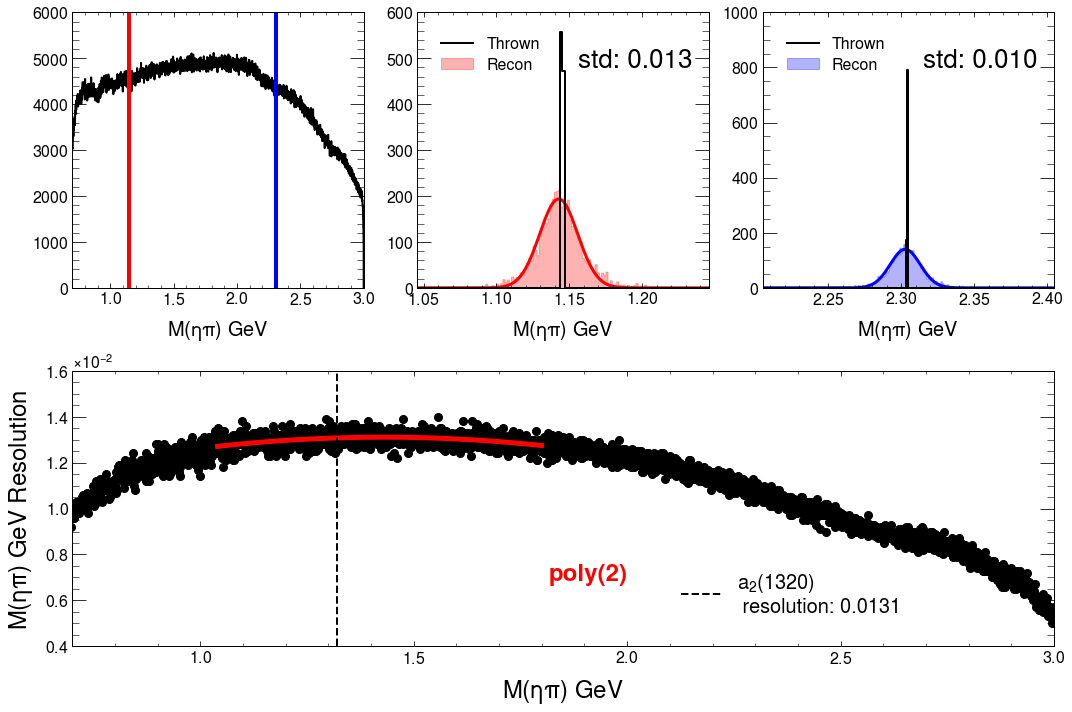

In [76]:
fig = plt.figure(figsize=(15,10))

ax1= fig.add_subplot(2,3,1)
ax2= fig.add_subplot(2,3,2)
ax3= fig.add_subplot(2,3,3)
ax4= fig.add_subplot(2,1,2)

### Mass resolution
hep.histplot(np.histogram(acc_df[resol_var],weights=acc_df.weightASBS,bins=edges),c='black',ax=ax1)
ax1.set_ylim(0)

if resol_var=="Mpi0eta":
    ax1.set_xlim(0.7,3)
elif resol_var=="mandelstam_t":
    ax1.set_xlim(0.1,1.0)
ax1.set_xlabel(resol_var_label)

def gaussian(x, A, mu, sig):
    return A/(np.sqrt(2.*np.pi)*sig)*np.exp(-np.power((x - mu)/sig, 2.)/2)

for ax, i, color in zip([ax2,ax3],[int(len(edges)*0.2),int(len(edges)*0.7)],["red","blue"]):
    ax1.axvline(edges[i],c=color,linewidth=4)
    tmp=acc_df[(acc_df[resol_var+"_thrown"]<edges[i])&(acc_df[resol_var+"_thrown"]>edges[i-1])]
    _edges=np.linspace(tmp[resol_var].min(),tmp[resol_var].max(),400)
    out=np.histogram(tmp[resol_var],weights=tmp.weightASBS,bins=_edges)
    intensity, _ = out
    center=_edges[:-1]+(_edges[1]-_edges[0])/2

    hep.histplot(out,ax=ax,label="Recon", alpha=0.3, histtype='fill',color=color)
    popt, pcov = curve_fit(gaussian, center, intensity, p0=(100,edges[i],0.01))
    ax.plot(center, gaussian(center, *popt), color=color, linewidth=3, linestyle='-',alpha=1)
    
    ax.text(0.55,0.8,f"std: {popt[2]:0.3f}", transform=ax.transAxes, size=26)
    hep.histplot(np.histogram(tmp[resol_var+"_thrown"],weights=[0.1]*len(tmp),bins=_edges),c='black',ax=ax,label="Thrown")
    ax.set_ylim(0)
    ax.set_xlim(edges[i]-0.1,edges[i]+0.1)
    ax.set_xlabel(resol_var_label)
    ax.legend(loc=2)


### DRAW RESOLUTION FIT PLOT
from scipy.optimize import curve_fit
def func(x, a, b, c):
    return a+b*x+c*x**2

if resol_var=="Mpi0eta":
    r=resolution[(centers>1.04)&(centers<1.80)]
    x=centers[(centers>1.04)&(centers<1.80)]
elif resol_var=="mandelstam_t":
    r=resolution
    x=centers

popt, pcov = curve_fit(func, x, r, p0=(1.0,0,0))
a,b,c=popt

if resol_var=="Mpi0eta":
    ax4.set_xlim(0.7,3)
elif resol_var=="mandelstam_t":
    ax4.set_xlim(0.1,1.0)

ax4.scatter(centers,resolution,c='black')
ax4.plot(x, func(x, *popt), 'r-', linewidth=5)
ax4.text(0.4,0.3,f"poly(2)",transform=axes.transAxes,size=24,c='red',weight="bold")

ax4.set_xlabel(resol_var_label,size=24)
ax4.set_ylabel(resol_var_label+" Resolution",size=24)
mass_pt=1.32
nearest_resolution=resolution[np.argmin(abs(centers-mass_pt))]
if resol_var=="Mpi0eta":
    ax4.axvline(mass_pt,c='black',linestyle='--', label=f"$a_2(1320)$\n resolution: {func(mass_pt, *popt):0.4f}")
ax4.legend(prop={"size":20},loc=4,bbox_to_anchor=(0.875,0))

plt.tight_layout()
plt.savefig('/d/grid17/ln16/dselector_v3/study_massResolution/massResolution.png')